# GAN Theory

>In short, the goal of the **Generative Adversarial Network** (GAN) is too:

$$ 
\begin{split}\begin{align*}
\min_G \max_D V(D,G) &= \mathbb{E}_{\boldsymbol{x}\sim p_{data}}[\log D(\boldsymbol{x})] \\
    & ~~ + \mathbb{E}_{\boldsymbol{z}\sim p_{\boldsymbol{z}}}[\log(1 - D(G(\boldsymbol{z}))]
\end{align*}\end{split}
$$

>Which it does utilizing some real data $\boldsymbol{x}$, some latent vector $\boldsymbol{z}$, the probability of the **discriminator** classifying real data $D(x)$, some fake data generated by the **generator** $G(z)$, and the probability of the discriminator classifying fake data as real $D(G(z))$.

## GAN Components

>Completely though, we require a number of components for our GAN architecture:

$P_{data}$: Samples from training dataset (unknown data distribution)

$P_{z}$: Generator's latent distribution

$P_{g}$: Generated data set (a distribution mapped to $P_{z}$)

$D$: Discriminator

$D.obj() \ \text{or} \ Objective(D)$: Maximize the probability of discerning real from fake data

$G$: Generator

>**Note:** The function that maps samples from $P_z$ to $P_g$: $ P_g = G(P_z)$ with the most optimal solution being $P_g = P_{data}$

$G.obj() \ \text{or} \ Objective(G)$: Minimize the probability from discerning/generate real from data

$\boldsymbol{x}$: real data sample from $P_{data}$

$\boldsymbol{z}$: latent vector

$D(\boldsymbol{x})$: Probability of classifying real data as real

$G(\boldsymbol{z})$: fake data (i.e., $P_g$)

$D(G(\boldsymbol{z}))$: probability of discriminator classifying fake data as real

>The two networks are trained iteratively, each with a separate loss function to be minimized:

$y$: binary label for real ($y=1$) or fake ($y=0$) data. 

$$ 
L_D = - [y \cdot \log(D(x))] + (1-y) \cdot \log(1-D(G(z)))]
$$

$$ 
L_G = - [(1-y) \cdot \log(1-D(G(z)))]
$$

$$
L_G = -1[(1-y) \cdot \log(D(G(z)))]
$$

## GAN Experiment: SNN
> Alright, but let's actually build a GAN...a quantum GAN. Practically, we'll implement the discriminator as some feedforward artificial neural network (ANN) with task of classification. For the generator, we'll implement using the patch method.

### Module Import: ANN + QC

In [1]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Module Imports: SNN

In [2]:
# Library imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

### Data: ANN

In [3]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

#### Dataloader Instance: ANN

In [104]:
image_size = 8  # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(
    csv_file="data/idea1.0/optdigits.tra", transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

#### Visualize Data: ANN

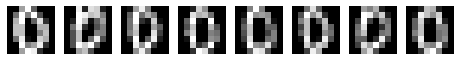

In [5]:
plt.figure(figsize=(8, 2))

for i in range(8):
    image = dataset[i][0].reshape(image_size, image_size)
    plt.subplot(1, 8, i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

### Data: SNN

>...

#### DataLoader Instance: SNN

In [392]:
# Training Parameters (dataloader arguments)
batch_size = 1
data_path = ''
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define a transform
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))])

# Training and Test data
mnist_train = datasets.MNIST(data_path, train=True, download=False, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=False, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

#### DataLoader Instance: ANN -> SNN: 16 x 16

In [395]:
# Training Parameters (dataloader arguments)
batch_size = 1
data_path = ''
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define a transform
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))])

# Training and Test data
mnist_train_16by16 = datasets.MNIST(data_path, train=True, download=False, transform=transform)
mnist_test_16by16 = datasets.MNIST(data_path, train=False, download=False, transform=transform)

# Create DataLoaders
train_loader_16by16 = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader_16by16 = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)


#### Visualize Data: SNN

In [7]:
# Check training and testing sets
print(mnist_train)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /Users/erickoduniyi/Desktop/Work/intelligent_interfaces/ai_art/ai_QGA{}/experiments/idea1/data/idea1.1/
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=(0,), std=(1,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: /Users/erickoduniyi/Desktop/Work/intelligent_interfaces/ai_art/ai_QGA{}/experiments/idea1/data/idea1.1/
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=(0,), std=(1,))
           )


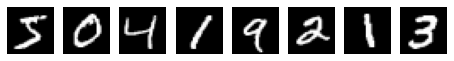

In [391]:
plt.figure(figsize=(28, 2))

image_size = 28

for i in range(8):
    image = mnist_train[i][0].reshape(image_size, image_size)
    plt.subplot(1, 28, i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()


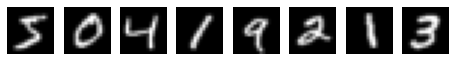

In [393]:
plt.figure(figsize=(16, 2))

image_size = 16

for i in range(8):
    image = mnist_train[i][0].reshape(image_size, image_size)
    plt.subplot(1, 16, i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()


>...

#### DataLoader Instance: SNN in the style of ANN
> So, the original QGAN uses MNIST image sizes of 8 x 8, and a relatively vanilla ANN architecture with a single output. On the other hand, the SNN tutorial sets the image sizes to 28 x 28, uses a more sophisticated network with an output layer of 10. For simplicity and initial experimentation, let's try and make the MNIST data and SNN model more like the ANN.

In [304]:
# Training Parameters (dataloader arguments)
batch_size = 1
data_path = ''
# num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define a transform
transform_small = transforms.Compose([
    transforms.Resize((8, 8)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))])

# Training and Test data
mnist_train_small = datasets.MNIST(data_path, train=True, download=False, transform=transform_small)
# mnist_test_small = datasets.MNIST(data_path, train=False, download=False, transform=transform_small)

# Create DataLoaders
# train_loader_small = DataLoader(mnist_train_small, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader_small = DataLoader(mnist_test_small, batch_size=batch_size, shuffle=True, drop_last=True)


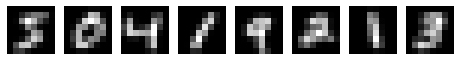

In [305]:
plt.figure(figsize=(8, 2))

image_size = 8

for i in range(8):
    image = mnist_train_small[i][0].reshape(image_size, image_size)
    plt.subplot(1, 8, i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

### Latency Coding of MNIST

>...

In [ ]:
def convert_to_time(data, tau=5, threshold=0.01):
  spike_time = tau * torch.log(data / (data - threshold))
  return spike_time

>...

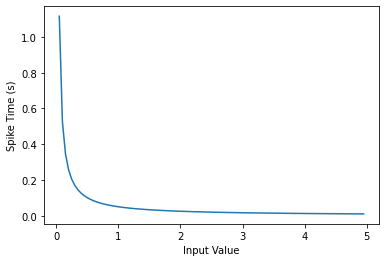

In [ ]:
raw_input = torch.arange(0, 5, 0.05)  # tensor from 0 to 5
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time (s)')
plt.show()

>...

In [ ]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

>...

In [ ]:
# Spiking Data
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)

>...

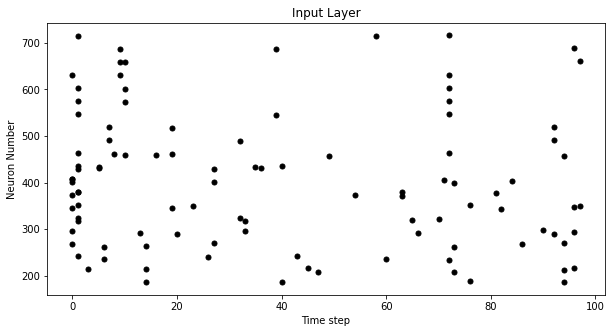

In [ ]:
import snntorch.spikeplot as splt
from IPython.display import HTML

num_steps = 100
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              clip=True, normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

>...

### Implementation of Discriminator: ANN

>We can use a fully connected neural network with two hidden layers. A single output will represent the probability of an input being classified as real. 

In [100]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (#features = 64)
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

### Implementation of Discriminator: ANN16by16

>We can use a fully connected neural network with two hidden layers. A single output will represent the probability of an input being classified as real. 

In [400]:
class DiscriminatorANN16by16(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (#features = 64)
            nn.Linear(image_size * image_size, 256),
            nn.ReLU(),
            # First hidden layer (256 -> 64)
            nn.Linear(256, 64),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

#### Visualizing Network: ANN

>...

In [ ]:
# from ann_visualizer.visualize import ann_viz

# # Load the network onto CUDA if available
# model_ann = Net().to(device)

# # Visualize network
# ann_viz(model_ann, title="")

### Implementation of Discriminator: SNN

>We can use a SNN to classify images as real. 

#### Leaky integrate-and-fire (LIF) neuron

>...

In [9]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0):
      super(LeakySurrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.spike_op = self.SpikeOperator.apply

  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.spike_op((mem-self.threshold))  # call the Heaviside function
    # removes spike_op gradient from reset
    reset = (spk * self.threshold).detach()
    mem = self.beta * mem + input_ - reset  # Eq (1)
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with the Spike itself
  @staticmethod
  class SpikeOperator(torch.autograd.Function):
      @staticmethod
      def forward(ctx, mem):
          spk = (mem > 0).float()  # Heaviside on the forward pass: Eq(2)
          # store the spike for use in the backward pass
          ctx.save_for_backward(spk)
          return spk

      @staticmethod
      def backward(ctx, grad_output):
          (spk,) = ctx.saved_tensors  # retrieve the spike
          grad = grad_output * spk  # scale the gradient by the spike: 1/0
          return grad

#### LIF Neuron Network

>...

In [10]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [11]:
# Define SNN Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

In [127]:
# Define SNN Network as a Discriminator
class DiscriminatorSNN(nn.Module):
    """Summary of class here.

    Longer class information....
    Longer class information....

    Attributes:
        boolean_var: A boolean indicating if we like SPAM or not.
        var: An integer count of the eggs we have laid.
    """
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        # self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.fc2 = nn.Linear(num_hidden, 1)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)


# Load the network onto CUDA if available
net = DiscriminatorSNN().to(device)

#### Visualizing Network: SNN

>...

In [66]:
# from ann_visualizer.visualize import ann_viz

# # Load the network onto CUDA if available
# model_snn = Net().to(device)

# # Visualize network
# ann_viz(model_snn, title="")

#### Training SNN

In [13]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")


def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

#### Training Loop: Loss + Optimization

>...

In [14]:
# Cross entropy
loss = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [82]:
batch_size = 128
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 62.27
Test Set Loss: 51.45
Train set accuracy for a single minibatch: 39.06%
Test set accuracy for a single minibatch: 32.03%


Epoch 0, Iteration 50
Train Set Loss: 18.09
Test Set Loss: 21.52
Train set accuracy for a single minibatch: 89.06%
Test set accuracy for a single minibatch: 88.28%


Epoch 0, Iteration 100
Train Set Loss: 9.65
Test Set Loss: 8.45
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 92.97%


Epoch 0, Iteration 150
Train Set Loss: 10.29
Test Set Loss: 9.27
Train set accuracy for a single minibatch: 89.84%
Test set accuracy for a single minibatch: 90.62%


Epoch 0, Iteration 200
Train Set Loss: 9.06
Test Set Loss: 7.36
Train set accuracy for a single minibatch: 94.53%
Test set accuracy for a single minibatch: 94.53%


Epoch 0, Iteration 250
Train Set Loss: 20.38
Test Set Loss: 6.88
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 92.19%


Epoch 0

### Plotting Results
>...

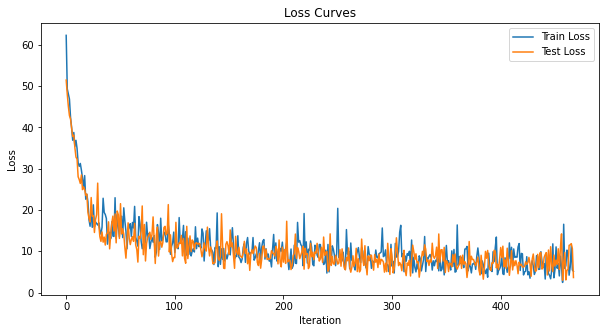

In [83]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

### Test Set Accuracy

>...

In [84]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(
    mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

In [85]:
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9366/10000
Test Set Accuracy: 93.66%


### Implementing the Generator

>The generator $G(z)$ is composed of a sum of sub generators $G^{(i)}$:

$$G(z) = \sum_n G^{(n)}$$

>Alright, so this is probably going to be the most complicated part of this build. Each of these sub generators share the same quantum circuit architecture. 
>
>The overall quantum generator consists of $N_G$ sub generators, each consisting of $N$ qubits. Anyways, the process from $\boldsymbol{z}$ to $G(z)$ can be broken up into 4 parts: state embedding, parameterisation, non-linear transformation, and post-processing. 

#### State Embedding

>The latent vector $\boldsymbol{z} \in \mathbb{R}^N$ is sampled from a uniform distribution in the interval $[0, \pi/2)$. All the sub generators get the same $\boldsymbol{z}$ which is then embedded using RY gates.

#### Parameterisation

>The parameterized RY gates followed by control Z gates. This layer is repeated $D$ times in total

#### Non-linear Transformation

>We need to get non-linear transformation mappings between $\boldsymbol{z}$ and $P_z$. This is accomplished with "ancillary" qubits. 
>
> For a given sub generator, the pre-measurement quantum state is given by:

$$\ket{\Psi(z)} = U_{G}(\theta)\ket{\boldsymbol{z}}$$

$\ket{\Psi} = \alpha \ket{0} + \beta \ket{1} $: Single qubit

$U_{G}(\theta)$: overall unitary of the parameterized layers

$\Pi:$ a partial measurement
>**Note**$:\Pi = (\ket{0}\bra{0})^{\otimes N_A}$

$\mathcal{A}$: ancillary subsystem

$\rho(\boldsymbol{z})$: post-measurement state
>**Note**: This is dependent on $\boldsymbol{z}$ in both the numerator and denominator. And hence, a non-linear transformation has occurred.

$$
\dfrac{\text{Tr}_{\mathcal{A}}(\Pi \otimes \mathbb{I}\ket{\Psi(\boldsymbol{z})}\bra{\Psi(\boldsymbol{z})})}{\bra{\Psi(\boldsymbol{z})}\Pi \otimes \mathbb{I}\ket{\Psi(\boldsymbol{z})}}
$$

>Alright, then with the other three qubits we will measure the probability of $\rho(\boldsymbol{z})$ in each computational basis state, $P(j)$, to obtain the sub generator output:

$$
\boldsymbol{g}^{(i)} = [P(0), P(1), \ ...  \ ,P(2^{N-N_A - 1})]
$$

#### Post-processing

> So because it turns out that all the elements in $\boldsymbol{g}^{(i)}$ need to sum to 1, we apply a post-processing technique to each patch:

$$
\boldsymbol{\tilde{x}^{(i)}} = \dfrac{\boldsymbol{g}^{(i)}}{\max_k\boldsymbol{g}_k^{(i)}}
$$

> And then the completely generated image is:

$$
\boldsymbol{\tilde{x}^{(i)}} = [\boldsymbol{\tilde{x}^{(1)}}, \ ... \ ,\boldsymbol{\tilde{x}^{(N_G)}}] 
$$

### Okay, let's get Quantum doe

In [287]:
# Quantum variables
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G

>Okay, we actually need to define the quantum device that this machine learning computation with run on

In [288]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

> Defining the quantum circuit that the GAN computation will run on

In [289]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)
    # print(weights.size())

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))

# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532

def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

> Dang, it's time to actually code the generator doe...

In [290]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)
        print("patch size: ", patch_size)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                print("q_out: ", q_out)
                patches = torch.cat((patches, q_out))
                print("patches: ", patches)

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

### Training: ANN

> Time to setup the training pipeline

> Learning rates and number of iterations for the training process

In [23]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

### Run Simulation: ANN

> Now, we can run the complete forward pass and training process

In [144]:
batch_size = 1
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Iteration count
# 
# 
counter = 0

# Collect images for plotting later
results = []

while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)
        print("real_data: ", real_data.size())

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)
        print("fake_data: ", fake_data.size())

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        print("outD_real: ", outD_real.size())
        # outD_fake = discriminator(fake_data.detach()).view(-1)
        print("outD_fake: ", outD_fake.size())

    #     errD_real = criterion(outD_real, real_labels)
    #     errD_fake = criterion(outD_fake, fake_labels)
        
    #     # Propagate gradients
    #     errD_real.backward()
    #     errD_fake.backward()

    #     errD = errD_real + errD_fake
    #     optD.step()

    #     # Training the generator
    #     generator.zero_grad()
    #     outD_fake = discriminator(fake_data).view(-1)
    #     errG = criterion(outD_fake, real_labels)
    #     errG.backward()
    #     optG.step()

    #     counter += 1

    #     # Show loss values
    #     if counter % 10 == 0:
    #         print(
    #             f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
    #         test_images = generator(fixed_noise).view(
    #             8, 1, image_size, image_size).cpu().detach()

    #         # Save images every 50 iterations
    #         if counter % 50 == 0:
    #             results.append(test_images)

    #     if counter == num_iter:
    #         break
    # if counter == num_iter:
    #     break


real_data:  torch.Size([1, 64])
fake_data:  torch.Size([1, 64])
outD_real:  torch.Size([1])
outD_fake:  torch.Size([1])
real_data:  torch.Size([1, 64])
fake_data:  torch.Size([1, 64])
outD_real:  torch.Size([1])
outD_fake:  torch.Size([1])
real_data:  torch.Size([1, 64])
fake_data:  torch.Size([1, 64])
outD_real:  torch.Size([1])
outD_fake:  torch.Size([1])
real_data:  torch.Size([1, 64])
fake_data:  torch.Size([1, 64])
outD_real:  torch.Size([1])
outD_fake:  torch.Size([1])
real_data:  torch.Size([1, 64])
fake_data:  torch.Size([1, 64])
outD_real:  torch.Size([1])
outD_fake:  torch.Size([1])
real_data:  torch.Size([1, 64])
fake_data:  torch.Size([1, 64])
outD_real:  torch.Size([1])
outD_fake:  torch.Size([1])
real_data:  torch.Size([1, 64])
fake_data:  torch.Size([1, 64])
outD_real:  torch.Size([1])
outD_fake:  torch.Size([1])
real_data:  torch.Size([1, 64])
fake_data:  torch.Size([1, 64])
outD_real:  torch.Size([1])
outD_fake:  torch.Size([1])
real_data:  torch.Size([1, 64])
fake_dat

KeyboardInterrupt: 

### Run Simulation: SNN

> Now, we can run the complete forward pass and training process

In [49]:
# print(iter(train_loader))
print(iter(dataloader))
print(len(iter(dataloader)))
# num_iter
# enumerate(dataloader)
# print(len(next(iter(train_loader))))
# print(len(train_loader))
print(len(iter(train_loader)))
# print(len(dataloader))
# print(len(train_batch))
# len(data)
# print(enumerate(train_loader).__sizeof__())
# print(enumerate(dataloader).__sizeof__())
# print(len(mnist_test))
# print(len(mnist_train))
# len(dataset)


375
468


In [64]:
# dataloader.reshape
# train_loader.batch_size

for data, _ in dataloader:

    # Data for training the discriminator
    data = data.reshape(-1, image_size * image_size)
    # print("data: ", data.size())
    # print(data)
    real_data = data.to(device)
    # print("real_data: ", real_data.size())
    # print(real_data)

In [73]:
# train_loader
# array = [44, 2, 3]

# (val1, _, _) = array  # initialize and value assignment to val1
# print(val1)          # output: 1
# len(train_loader)
print(len(iter(train_loader)))
print(len(iter(dataloader)))


468
375


In [24]:
# batch_size = 128
# torch.full((batch_size,), 1.0, dtype=torch.float, device=device)data.reshape(-1, image_size * image_size)
# print(len(data.reshape(-1, image_size * image_size)))
# print(len(data.to(device)))
print(len(torch.full((batch_size,), 1.0, dtype=torch.float, device=device)))
print(len(torch.rand(8, n_qubits, device=device) * math.pi / 2))


128
8


In [120]:
# len(fake_data.detach())
print(len(real_data))
# discriminator(real_data).view(-1)
print(real_data.size())


1
torch.Size([1, 64])


In [334]:
import math
# -math.log2(8)
n_qubits = 5  # Total number of qubits / N
n_a_qubits = math.log2(196)  # Number of ancillary qubits / N_A
# 2 ** (n_qubits - n_a_qubits)
# print(n_qubits - n_a_qubits)
# 2 ^ (5 - (5 - log2(196)))
math.floor(2 ** (n_qubits - (n_qubits - n_a_qubits)))
# n_qubits - n_a_qubits


196

In [325]:
# 2 ** (5 - -6)
2 ** 11

2048

#### Model Testbed: Quantum Generator

> This version of the Quantum Circuit/Generation has print statements to aid in the debugging. Consequently, when performing normal runs, the output is very verbose and annoying. So, this version of the mode/circuit is best ran with other blocks like `Size Testing` or similar testing blocks

In [398]:
# Quantum variables
# n_qubits = 5  # Total number of qubits / N
n_qubits = 7  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
# n_a_qubits = n_qubits - math.log2(196)  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G

# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Quantum node
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)
    print("weight: ", weights.size())
    print("noise: ", noise.size())


    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))

# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532

# Quantum measurement
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    print("probs: ", probs.size())
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    # probsgiven0 = probs[: math.floor((2 ** (n_qubits - n_a_qubits)))]
    # probsgiven0 = probs[: 16]
    print("probsgiven0: ", probsgiven0.size())
    print("torch.sum: ", torch.sum(probs).size())
    probsgiven0 /= torch.sum(probs)
    print("probsgivensum: ", probsgiven0.size())

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    print("probsgiven: ", probsgiven.size())
    return probsgiven

# Quantum generator
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialization.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)
        # patch_size = math.floor(2 ** (n_qubits - n_a_qubits))
        
        # patch_size = 16
        print("patch_size: ", patch_size)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)
        print("images: ", images.size())

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            print("patches0: ", patches.size())
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                print("q_out: ", q_out.size())
                patches = torch.cat((patches, q_out))
                print("patches: ", patches.size())

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images


#### Model: Quantum Generator

>...

In [408]:
# Quantum variables
# n_qubits = 5  # Total number of qubits / N
n_qubits = 7  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
# n_a_qubits = n_qubits - math.log2(196)  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G

# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)

# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Quantum node
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)
    # print("weight: ", weights.size())
    # print("noise: ", noise.size())


    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))

# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532

# Quantum measurement
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    # print("probs: ", probs.size())
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    # probsgiven0 = probs[: math.floor((2 ** (n_qubits - n_a_qubits)))]
    # probsgiven0 = probs[: 16]
    # print("probsgiven0: ", probsgiven0.size())
    # print("torch.sum: ", torch.sum(probs).size())
    probsgiven0 /= torch.sum(probs)
    # print("probsgivensum: ", probsgiven0.size())

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    # print("probsgiven: ", probsgiven.size())
    return probsgiven

# Quantum generator
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialization.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)
        # patch_size = math.floor(2 ** (n_qubits - n_a_qubits))
        
        # patch_size = 16
        # print("patch_size: ", patch_size)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)
        # print("images: ", images.size())

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            # print("patches0: ", patches.size())
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                # print("q_out: ", q_out.size())
                patches = torch.cat((patches, q_out))
                # print("patches: ", patches.size())

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images


#### Training: `qml(ANN16by16, QC)`

> Alright, so I noticed that the resolution of the images being used in the [Quantum GANs](https://pennylane.ai/qml/demos/tutorial_quantum_gans.html) was very poor because `image_size = 8` (i.e., pixels/image = 64); this highlighted in the `DataLoader Instance` sections). Have such a low resolution was done to keep the #qubits and other parameters of the network smaller, however I don't think it's useful beyond demonstrating the pipeline. In fact, the SNN tutorial sets the MNIST `image_size = 28` a total of 784 pixels per picture, which may require a significantly larger amount of qubits (i.e., > 8). Additionally, the number of examples used in the QGAN tutorial is 367...over 500 iterations? While the SNN tutorial uses the full 6e4 examples. So, in an attempt to first run the MNIST dataset with a larger feature size and significantly more iterations...

In [409]:
# Set DataLoader arguments here
batch_size = 1 #! probably first breaking point: toggle between 128 and 1

# Set Training parameters
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the ANN discriminator
# lrD = 5e-4 # Learning rate for the SNN discriminator
# num_iter = 500  # Number of training iterations
num_iter = len(train_loader_16by16) #! probably another breaking point: toggle between 500 and 468

# discriminator = Discriminator().to(device)
discriminator = DiscriminatorANN16by16().to(device)
# discriminator = DiscriminatorSNN().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss() # I actually might want to use this considering SNN: 784 -> 1000 -> 1
# criterion = nn.CrossEntropyLoss() #! probably another breaking point: toggle between BCE and Cross

# Optimizers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
# optD = torch.optim.Adam(discriminator.parameters(), lr=lrD, betas=(0.9, 0.999))
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(16, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

# It's weird, ANN specifies 500 for num_iter but dataloader has a length of 375 (#iterations/#batches)
# SNN train_loader has a length of 468 (#iterations/#batches)
# dataloader = iter(train_loader)
dataloaderANN16by16 = train_loader_16by16

while True:
    for i, (data, _) in enumerate(dataloaderANN16by16):
    # for (data, _) in dataloader: #! probably another breaking point: toggle between dataloader and dataloaderSNN

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        # data = data.reshape(-1, num_inputs)
        real_data = data.to(device) #! probably another breaking point: where is image_size
        # print("real_data: ", real_data.size())
        
        #! probably another breaking point: I might need to incorporate the forward pass: switch between `qml(SNN, QC)` and `SNN(self, QC)`
        
        # Noise following a uniform distribution in range [0,pi/2)
        batch_size = 1
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)
        # print("fake_data: ", fake_data.size())

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1) #getting (3584x28 and 784x1000)
        # outD_real = discriminator(real_data).view(-1)
        # print("outD_real: ", outD_real.size())
        outD_fake = discriminator(fake_data.detach()).view(-1) #getting (128x64 and 784x1000)
        # print("outD_fake: ", outD_fake.size())

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(16,1,image_size,image_size).cpu().detach()

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    if counter == num_iter:
        break

Iteration: 10, Discriminator Loss: 1.376, Generator Loss: 0.700
Iteration: 20, Discriminator Loss: 1.378, Generator Loss: 0.707
Iteration: 30, Discriminator Loss: 1.350, Generator Loss: 0.697
Iteration: 40, Discriminator Loss: 1.370, Generator Loss: 0.706
Iteration: 50, Discriminator Loss: 1.344, Generator Loss: 0.708
Iteration: 60, Discriminator Loss: 1.349, Generator Loss: 0.713
Iteration: 70, Discriminator Loss: 1.366, Generator Loss: 0.716
Iteration: 80, Discriminator Loss: 1.303, Generator Loss: 0.716
Iteration: 90, Discriminator Loss: 1.348, Generator Loss: 0.695
Iteration: 100, Discriminator Loss: 1.304, Generator Loss: 0.711
Iteration: 110, Discriminator Loss: 1.301, Generator Loss: 0.703
Iteration: 120, Discriminator Loss: 1.310, Generator Loss: 0.703
Iteration: 130, Discriminator Loss: 1.244, Generator Loss: 0.713
Iteration: 140, Discriminator Loss: 1.313, Generator Loss: 0.722
Iteration: 150, Discriminator Loss: 1.333, Generator Loss: 0.694
Iteration: 160, Discriminator Loss

KeyboardInterrupt: 

### Demo Results: ANN16by16

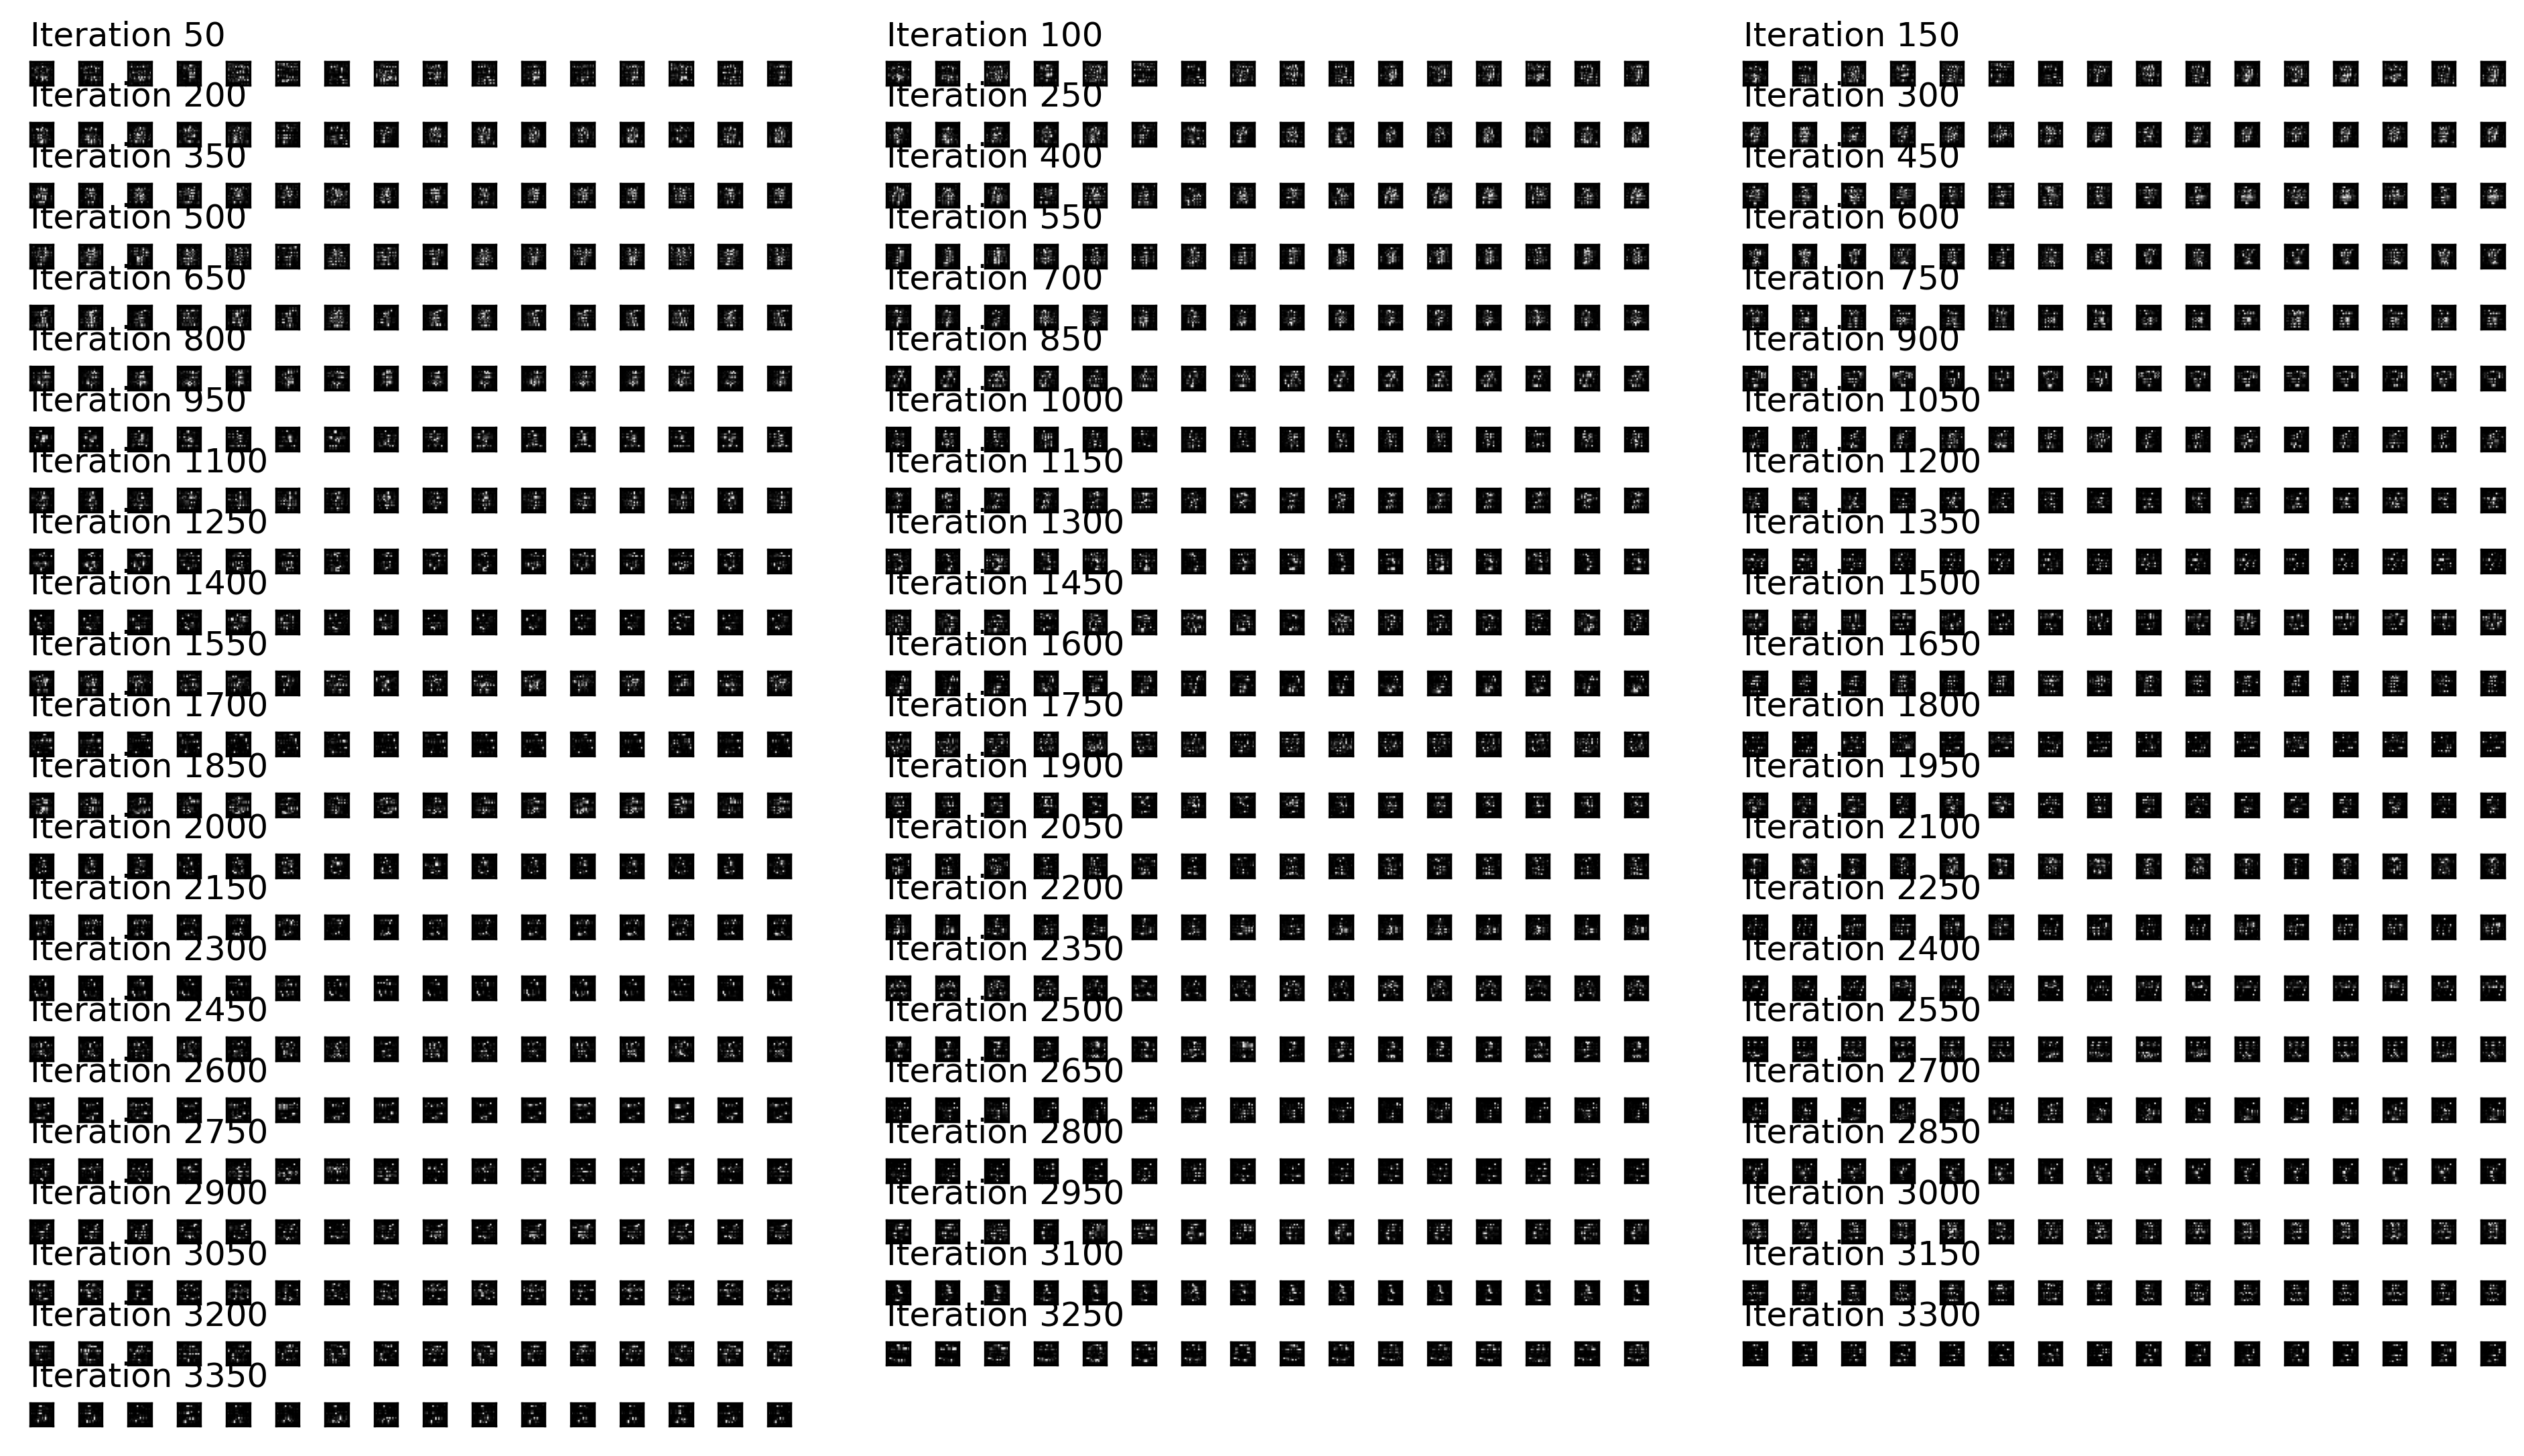

In [452]:
fig = plt.figure(figsize=(16, 16), dpi=300)
outer = gridspec.GridSpec(40, 3, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(2, images.size(0), subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()

#### Training: `qml(SNN, QC)`

In [169]:
# Set DataLoader arguments here
batch_size = 1 #! probably first breaking point: toggle between 128 and 1

# Set Training parameters
lrG = 0.3  # Learning rate for the generator
# lrD = 0.01  # Learning rate for the ANN discriminator
lrD = 5e-4 # Learning rate for the SNN discriminator
# num_iter = 500  # Number of training iterations
num_iter = len(train_loader) #! probably another breaking point: toggle between 500 and 468

# discriminator = Discriminator().to(device)
# discriminator = Discriminator().to(device)
# discriminator = DiscriminatorSNN().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss() # I actually might want to use this considering SNN: 784 -> 1000 -> 1
# criterion = nn.CrossEntropyLoss() #! probably another breaking point: toggle between BCE and Cross

# Optimizers
# optD = optim.SGD(discriminator.parameters(), lr=lrD)
optD = torch.optim.Adam(discriminator.parameters(), lr=lrD, betas=(0.9, 0.999))
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

# It's weird, ANN specifies 500 for num_iter but dataloader has a length of 375 (#iterations/#batches)
# SNN train_loader has a length of 468 (#iterations/#batches)
# dataloader = iter(train_loader)
dataloaderSNN = train_loader

while True:
    for i, (data, _) in enumerate(dataloaderSNN):
    # for (data, _) in dataloader: #! probably another breaking point: toggle between dataloader and dataloaderSNN

        # Data for training the discriminator
        # data = data.reshape(-1, image_size * image_size)
        data = data.reshape(-1, num_inputs)
        real_data = data.to(device) #! probably another breaking point: where is image_size
        print("real_data: ", real_data.size())
        
        #! probably another breaking point: I might need to incorporate the forward pass: switch between `qml(SNN, QC)` and `SNN(self, QC)`
        
        # Noise following a uniform distribution in range [0,pi/2)
        batch_size = 128
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)
        print("fake_data: ", fake_data.size())

        # # Training the discriminator
        discriminator.zero_grad()
        # outD_real = discriminator(real_data).view(-1) #getting (3584x28 and 784x1000)
        # outD_real = discriminator(real_data).view(-1)
        print("outD_real: ", outD_real.size())
        outD_fake = discriminator(fake_data.detach()).view(-1) #getting (128x64 and 784x1000)
        print("outD_fake: ", outD_fake.size())

        # errD_real = criterion(outD_real, real_labels)
        # errD_fake = criterion(outD_fake, fake_labels)
        # # Propagate gradients
        # errD_real.backward()
        # errD_fake.backward()

        # errD = errD_real + errD_fake
        # optD.step()

    #     # Training the generator
    #     generator.zero_grad()
    #     outD_fake = discriminator(fake_data).view(-1)
    #     errG = criterion(outD_fake, real_labels)
    #     errG.backward()
    #     optG.step()

    #     counter += 1

    #     # Show loss values
    #     if counter % 10 == 0:
    #         print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
    #         test_images = generator(fixed_noise).view(8,1,image_size,image_size).cpu().detach()

    #         # Save images every 50 iterations
    #         if counter % 50 == 0:
    #             results.append(test_images)

    #     if counter == num_iter:
    #         break
    # if counter == num_iter:
    #     break

real_data:  torch.Size([128, 784])
fake_data:  torch.Size([128, 64])
outD_real:  torch.Size([1])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x64 and 784x1000)

#### Size Testing

In [399]:
# batch_size = 128
batch_size = 1
generator = PatchQuantumGenerator(n_generators).to(device)
# n_qubits = 5
# var = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
print(noise)
print(noise.size())
print(len(noise))

generator(noise).size()

tensor([[0.4806, 1.3154, 1.4672, 0.5741, 1.2651, 0.7558, 0.9788]])
torch.Size([1, 7])
1
patch_size:  64
images:  torch.Size([1, 0])
patches0:  torch.Size([0, 64])
weight:  torch.Size([6, 7])
noise:  torch.Size([7])
probs:  torch.Size([128])
probsgiven0:  torch.Size([64])
torch.sum:  torch.Size([])
probsgivensum:  torch.Size([64])
probsgiven:  torch.Size([64])
q_out:  torch.Size([1, 64])
patches:  torch.Size([1, 64])
patches0:  torch.Size([0, 64])
weight:  torch.Size([6, 7])
noise:  torch.Size([7])
probs:  torch.Size([128])
probsgiven0:  torch.Size([64])
torch.sum:  torch.Size([])
probsgivensum:  torch.Size([64])
probsgiven:  torch.Size([64])
q_out:  torch.Size([1, 64])
patches:  torch.Size([1, 64])
patches0:  torch.Size([0, 64])
weight:  torch.Size([6, 7])
noise:  torch.Size([7])
probs:  torch.Size([128])
probsgiven0:  torch.Size([64])
torch.sum:  torch.Size([])
probsgivensum:  torch.Size([64])
probsgiven:  torch.Size([64])
q_out:  torch.Size([1, 64])
patches:  torch.Size([1, 64])
patc

torch.Size([1, 256])

In [388]:
# batch_size = 128
batch_size = 1
generator = PatchQuantumGenerator(n_generators).to(device)
# n_qubits = 5
# var = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
print(noise)
print(noise.size())
print(len(noise))

generator(noise).size()

tensor([[1.1509, 0.4234, 0.5485, 0.7210, 1.0257]])
torch.Size([1, 5])
1
patch_size:  16
images:  torch.Size([1, 0])
patches0:  torch.Size([0, 16])
weight:  torch.Size([6, 5])
noise:  torch.Size([5])
probs:  torch.Size([32])
probsgiven0:  torch.Size([16])
torch.sum:  torch.Size([])
probsgivensum:  torch.Size([16])
probsgiven:  torch.Size([16])
q_out:  torch.Size([1, 16])
patches:  torch.Size([1, 16])
patches0:  torch.Size([0, 16])
weight:  torch.Size([6, 5])
noise:  torch.Size([5])
probs:  torch.Size([32])
probsgiven0:  torch.Size([16])
torch.sum:  torch.Size([])
probsgivensum:  torch.Size([16])
probsgiven:  torch.Size([16])
q_out:  torch.Size([1, 16])
patches:  torch.Size([1, 16])
patches0:  torch.Size([0, 16])
weight:  torch.Size([6, 5])
noise:  torch.Size([5])
probs:  torch.Size([32])
probsgiven0:  torch.Size([16])
torch.sum:  torch.Size([])
probsgivensum:  torch.Size([16])
probsgiven:  torch.Size([16])
q_out:  torch.Size([1, 16])
patches:  torch.Size([1, 16])
patches0:  torch.Size([

torch.Size([1, 64])

In [365]:
# batch_size = 128
batch_size = 1
generator = PatchQuantumGenerator(n_generators).to(device)
# n_qubits = 5
# var = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
print(noise)
print(noise.size())
print(len(noise))

generator(noise).size()

tensor([[0.3469, 0.9927, 0.8773, 1.1799, 0.9750]])
torch.Size([1, 5])
1
patch size:  16
images:  torch.Size([1, 0])
patches0:  torch.Size([0, 16])
weight:  torch.Size([6, 5])
q_out:  torch.Size([1, 16])
patches:  torch.Size([1, 16])
patches0:  torch.Size([0, 16])
weight:  torch.Size([6, 5])
q_out:  torch.Size([1, 16])
patches:  torch.Size([1, 16])
patches0:  torch.Size([0, 16])
weight:  torch.Size([6, 5])
q_out:  torch.Size([1, 16])
patches:  torch.Size([1, 16])
patches0:  torch.Size([0, 16])
weight:  torch.Size([6, 5])
q_out:  torch.Size([1, 16])
patches:  torch.Size([1, 16])


torch.Size([1, 64])

In [237]:
# torch.rand(q_depth * n_qubits).size()
# torch.Tensor(x.size(0), 0)
patch = torch.Tensor(0, 16)



0

### Demo Results



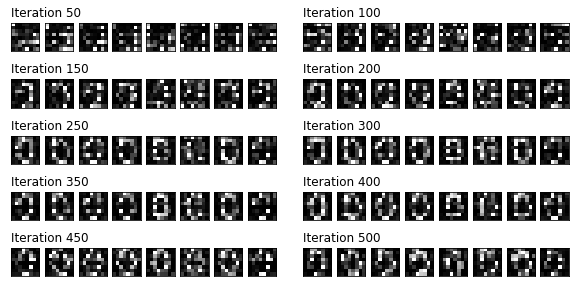

In [25]:
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()